In [ ]:
from preprocess import preprocess_data
from transformers import AutoTokenizer
from datasets import Dataset
import pandas as pd, torch, numpy as np
from tqdm.auto import tqdm, trange

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

## Process data

In [ ]:
model_name = "cointegrated/rubert-tiny-sentiment-balanced"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
df = pd.read_excel('./a_with_labels.xlsx')
df = df[['Text', 'my-label']].rename(columns={'Text': 'text', 'my-label': 'label'})

dataset = Dataset.from_pandas(df)

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

### Other dataset

In [ ]:
from datasets import load_dataset

def map_sentiment(x):
    x['sentiment'] = {0: 'neutral', 1: 'positive', 2: 'negative'}[x['sentiment']]
    return x

dataset = load_dataset("MonoHime/ru_sentiment_dataset").remove_columns('Unnamed: 0')
dataset['test'] = dataset.pop('validation')
dataset = dataset.map(map_sentiment)
dataset = dataset.rename_column("sentiment", "label")

## Finetune a model

In [ ]:
from transformers import AutoModelForSequenceClassification

model_name = "cointegrated/rubert-tiny-sentiment-balanced"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).cuda()

In [ ]:
model.config.id2label

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_fn(tokenizer): 
    # this fixes multiprocessing issue
    def _f(x): return tokenizer(x["text"], truncation=True)
    return _f


ds = dataset.\
    map(tokenize_fn(tokenizer), batched=True, remove_columns=['text'], num_proc=6).\
    map(lambda x: {'label': [model.config.label2id[xl] for xl in x['label']]}, batched=True)

## Code for eval and predict

In [ ]:
import evaluate

def to_np(x): return x.detach().cpu().numpy()


def predict(model, dl):
    preds, targets = np.array([]), np.array([])
    for batch in tqdm(dl):
        batch = batch.to(model.device)
        with torch.no_grad():
            logits = model(**batch).logits
            preds = np.append(preds, to_np(logits.argmax(-1)), axis=0)
            targets = np.append(targets, to_np(batch["labels"]), axis=0)
            
    return preds, targets

def do_eval(model, dl):
    metrics = ["accuracy", "precision", "recall", "f1"]
    preds, targets = predict(model, dl)
    results = {}
    for metric in metrics:
        metric_obj = evaluate.load(metric)
        kwargs = {} if metric == "accuracy" else {"average": "macro"}
        results[metric] = metric_obj.compute(predictions=preds, references=targets, **kwargs)
    return results

In [ ]:
model.train()
cleanup()

In [ ]:
import matplotlib.pyplot as plt

def update_graph(points: list[list], graph_ax, graph_out, names=None, x_bounds=None, y_bounds=None):
    graph_ax.clear()
    for i, p in enumerate(points): graph_ax.plot(*p, label=names[i] if names else None)
    graph_ax.legend(loc='upper right')
    if x_bounds is not None: graph_ax.set_xlim(*x_bounds)
    if y_bounds is not None: graph_ax.set_ylim(*y_bounds)
    graph_out.update(graph_ax.figure)

In [ ]:
def get_loss(model, dl):
    total_loss = 0.0
    total_batches = 0
    with torch.no_grad():
        for batch in tqdm(dl, leave=True):
            batch = batch.to(model.device)
            total_loss += model(**batch).loss.item()
            total_batches += 1
    return total_loss / total_batches if total_batches > 0 else 0.0

## Training loop

In [ ]:
from torch.utils.data import DataLoader

bs = 128
dl_train = DataLoader(ds["train"], shuffle=True, collate_fn=data_collator, batch_size=bs)
dl_test = DataLoader(ds["test"], shuffle=False, collate_fn=data_collator, batch_size=bs)

In [ ]:
from types import SimpleNamespace

config = SimpleNamespace(
n_epochs = 3,
window = 500,
cleanup_step = 100,
eval_step = 64
)
# reinitialize model in case we want to change parameters and restart training from scratch
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).cuda()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [ ]:
def train(model, optimizer, dl_train, dl_test, config):
    fig, ax = plt.subplots(figsize=(9,4))
    graph_out = display(fig, display_id=True)
    eval_steps = []
    losses, test_losses = [], []
    step, ewm_loss = 0, 0
    try:
        for _ in trange(config.n_epochs):
            for i, batch in enumerate(tqdm(dl_train, leave=True)):
                step += 1
                batch = batch.to(model.device)
                output = model(**batch)
                loss = output.loss
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
                
                if i % config.cleanup_step == 0: cleanup()

                w = 1 / min(i+1, config.window)
                ewm_loss = ewm_loss * (1-w) + loss.item() * w
                losses.append(loss.item())
                
                if i % config.eval_step == 0:
                    eval_steps.append(step)
                    model.eval()
                    eval_loss = get_loss(model, dl_test)
                    test_losses.append(eval_loss)
                    model.train()
                update_graph([[losses], [eval_steps, test_losses]], ax, graph_out, names=['loss', 'test loss'])
    except KeyboardInterrupt: print("Stopping training")

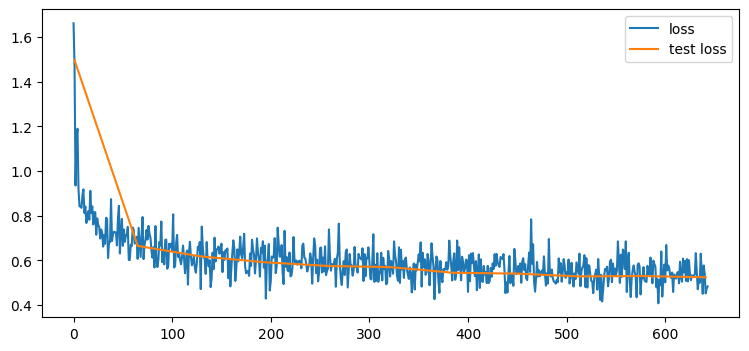

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1484 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

Stopping training


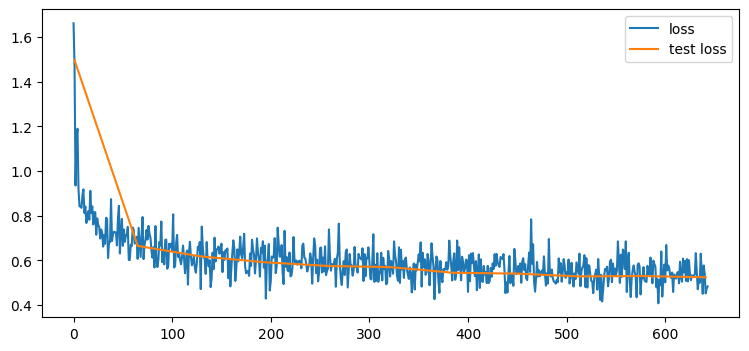

In [ ]:
train(model, optimizer, dl_train, dl_test, config)

In [ ]:
model.save_pretrained('./tuned_model')

# Eval model

In [ ]:
do_eval(model, dl_test)

  0%|          | 0/165 [00:00<?, ?it/s]

{'accuracy': {'accuracy': 0.7562328182766139},
 'precision': {'precision': 0.7488611519762216},
 'recall': {'recall': 0.7375669614197595},
 'f1': {'f1': 0.7425991263875398}}